# THE COMMUNITY EARTH SYSTEM MODEL (CESM) LARGE ENSEMBLE PROJECT

Paper: https://journals.ametsoc.org/doi/pdf/10.1175/BAMS-D-13-00255.1

Authors: Kay et al. 2015

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#THE-COMMUNITY-EARTH-SYSTEM-MODEL-(CESM)-LARGE-ENSEMBLE-PROJECT" data-toc-modified-id="THE-COMMUNITY-EARTH-SYSTEM-MODEL-(CESM)-LARGE-ENSEMBLE-PROJECT-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>THE COMMUNITY EARTH SYSTEM MODEL (CESM) LARGE ENSEMBLE PROJECT</a></span><ul class="toc-item"><li><span><a href="#Learning-Objectives" data-toc-modified-id="Learning-Objectives-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Learning Objectives</a></span></li><li><span><a href="#Create-Dask-Cluster" data-toc-modified-id="Create-Dask-Cluster-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create Dask Cluster</a></span></li><li><span><a href="#Load-data-into-xarray-from-an-intake-esm-catalog" data-toc-modified-id="Load-data-into-xarray-from-an-intake-esm-catalog-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load data into xarray from an intake-esm catalog</a></span></li><li><span><a href="#Get-Observation-data-(HadCRUT4;-Morice-et-al.-2012)" data-toc-modified-id="Get-Observation-data-(HadCRUT4;-Morice-et-al.-2012)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Get Observation data (HadCRUT4; Morice et al. 2012)</a></span></li><li><span><a href="#Compute-areacella" data-toc-modified-id="Compute-areacella-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Compute areacella</a></span></li><li><span><a href="#Compute-weighted-spatial-means-for-model-data" data-toc-modified-id="Compute-weighted-spatial-means-for-model-data-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Compute weighted spatial means for model data</a></span></li><li><span><a href="#Compute-weighted-temporal-mean-for-obs-data" data-toc-modified-id="Compute-weighted-temporal-mean-for-obs-data-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Compute weighted temporal mean for obs data</a></span></li><li><span><a href="#Confirm-that-after-using-area-weighted-average,-max-temp-increase-is-5k" data-toc-modified-id="Confirm-that-after-using-area-weighted-average,-max-temp-increase-is-5k-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Confirm that after using area weighted average, max temp increase is 5k</a></span></li><li><span><a href="#Figure-2:-Global-surface-temperature-anomaly-(1961-90-base-period)-for-individual-ensemble-members,-and-observations" data-toc-modified-id="Figure-2:-Global-surface-temperature-anomaly-(1961-90-base-period)-for-individual-ensemble-members,-and-observations-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Figure 2: Global surface temperature anomaly (1961-90 base period) for individual ensemble members, and observations</a></span></li><li><span><a href="#Compute-Linear-Trend-for-boreal-winter-seasons-(DJF)" data-toc-modified-id="Compute-Linear-Trend-for-boreal-winter-seasons-(DJF)-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Compute Linear Trend for boreal winter seasons (DJF)</a></span></li><li><span><a href="#Figure-4:-Global-maps-of-historical-(1979---2012)-boreal-winter-(DJF)-surface-air-trends" data-toc-modified-id="Figure-4:-Global-maps-of-historical-(1979---2012)-boreal-winter-(DJF)-surface-air-trends-1.11"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>Figure 4: Global maps of historical (1979 - 2012) boreal winter (DJF) surface air trends</a></span></li><li><span><a href="#Going-Further" data-toc-modified-id="Going-Further-1.12"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>Going Further</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import intake
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
import dask
dask.config.set({'distributed.dashboard.link': '/proxy/{port}/status'})

## Learning Objectives

## Create Dask Cluster

In [4]:
cluster = NCARCluster(memory="40GB")
cluster.adapt(minimum=1, maximum=200, wait_count=60)
cluster

In [5]:
client = Client(cluster)
client

Client Scheduler: tcp://10.12.203.5:40606 Dashboard: /proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
col = intake.open_esm_metadatastore(collection_name='CESM1-LE')

In [7]:
col

CESM1-LE collection catalogue with 146462 entries:
	> 6 resource(s)

	> 1 resource_type(s)

	> 1 direct_access(s)

	> 6 experiment(s)

	> 93 case(s)

	> 6 component(s)

	> 13 stream(s)

	> 820 variable(s)

	> 89 date_range(s)

	> 41 member_id(s)

	> 146462 file_fullpath(s)

	> 146462 file_basename(s)

	> 1 ctrl_branch_year(s)

	> 1 year_offset(s)

	> 2 sequence_order(s)

	> 3 grid(s)

In [8]:
col.df.head()

,resource,resource_type,direct_access,experiment,case,component,stream,variable,date_range,member_id,file_fullpath,file_basename,ctrl_branch_year,year_offset,sequence_order,grid
index,,,,,,,,,,,,,,,,
0,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,PRECTMX,04020101-04991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECTMX.040...,NaN,1448.0,0,
1,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,PRECTMX,05000101-05991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECTMX.050...,NaN,1448.0,0,
2,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,PRECTMX,06000101-06991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECTMX.060...,NaN,1448.0,0,
3,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,PRECTMX,07000101-07991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECTMX.070...,NaN,1448.0,0,
4,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,PRECTMX,08000101-08991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECTMX.080...,NaN,1448.0,0,


## Load data into xarray from an intake-esm catalog

In [9]:
_, ds_20C = col.search(component='atm', stream='cam.h1', variable='TREFHT', experiment='20C').to_xarray(chunks={'time': 712}, override_coords=True).popitem()
_, ds_rcp = col.search(component='atm', stream='cam.h1', variable='TREFHT', experiment='RCP85').to_xarray(chunks={'time': 712}, override_coords=True).popitem()
t_20c = ds_20C['TREFHT']
t_rcp = ds_rcp['TREFHT']

In [10]:
t_ref = t_20c.sel(time=slice('1961', '1990'))
t_ref

<xarray.DataArray 'TREFHT' (member_id: 40, time: 10950, lat: 192, lon: 288)>
dask.array<shape=(40, 10950, 192, 288), dtype=float32, chunksize=(1, 69, 192, 288)>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1961-01-01 00:00:00 ... 1990-12-31 00:00:00
  * member_id  (member_id) float64 1.0 2.0 3.0 4.0 ... 102.0 103.0 104.0 105.0
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

## Get Observation data (HadCRUT4; Morice et al. 2012)

In [11]:
ds = xr.open_dataset('https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/cru/hadcrut4/air.mon.anom.median.nc').load()
obs = ds['air']
obs

<xarray.DataArray 'air' (time: 2035, lat: 36, lon: 72)>
array([[[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan, 1.833333, ...,      nan,      nan],
        [1.190512,      nan, ...,      nan, 0.35862 ],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,     

## Compute areacella


Area element: $\delta A = R^2 \delta \phi \delta \lambda \cos(\phi)$
    
where ϕ is latitude, δϕ is the spacing of the points in latitude, δλ is the spacing of the points in longitude, and R is Earth's radius. (In this formula, ϕ and λ are measured in radians.)

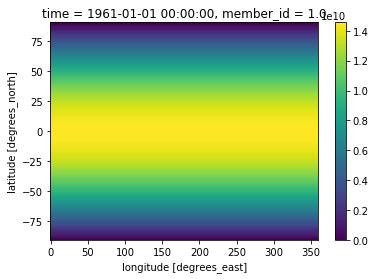

In [12]:
R = 6.371e6
total_area = (4 * np.pi * R**2)
dϕ = np.radians((t_ref['lat'][1]-t_ref['lat'][0]).values)
dλ = np.radians((t_ref['lon'][1]-t_ref['lon'][0]).values)
dA = R**2 * np.abs(dϕ * dλ) * np.cos(np.radians(t_ref.lat))
areacella = dA * (0 * t_ref.isel(member_id=0, time=0) + 1)
areacella.plot()

In [13]:
areacella.sum().values / total_area

0.9999774548191736

## Compute weighted spatial means for model data

In [14]:
t_ref_ts = ((t_ref.resample(time='AS').mean('time') * areacella)\
             .sum(dim=('lat', 'lon')) / total_area)\
             .mean(dim=('time', 'member_id'))
t_20c_ts = ((t_20c.resample(time='AS').mean('time') * areacella)\
            .sum(dim=('lat', 'lon'))) / total_area
t_rcp_ts = ((t_rcp.resample(time='AS').mean('time') * areacella)\
            .sum(dim=('lat', 'lon'))) / total_area

In [15]:
t_ref_mean = t_ref_ts.load()
t_ref_mean

Unknown job_id: 3352151 for worker tcp://10.12.205.17:40395


<xarray.DataArray ()>
array(286.382846)

In [16]:
t_20c_ts_df = t_20c_ts.to_series().unstack().T
t_20c_ts_df.head()

member_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,31.0,32.0,33.0,34.0,35.0,101.0,102.0,103.0,104.0,105.0
time,,,,,,,,,,,,,,,,,,,,,
1850-01-01 00:00:00,286.208878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1851-01-01 00:00:00,286.277452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1852-01-01 00:00:00,286.252334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1853-01-01 00:00:00,286.245479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1854-01-01 00:00:00,286.154363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
t_rcp_ts_df = t_rcp_ts.to_series().unstack().T
t_rcp_ts_df.head()

member_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,31.0,32.0,33.0,34.0,35.0,101.0,102.0,103.0,104.0,105.0
time,,,,,,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,286.760026,286.955533,286.674387,286.788293,286.749729,287.017492,286.845684,287.084996,286.955187,286.770964,...,286.861259,286.920223,286.659134,286.950573,286.707659,287.110750,286.858740,286.876884,287.303575,287.025493
2007-01-01 00:00:00,287.068956,286.903695,286.803925,286.994040,286.836832,286.988197,286.909294,286.934080,286.928714,286.670544,...,286.799288,286.844728,286.623375,287.005641,286.806677,287.182372,286.858032,287.003429,287.217655,287.234198
2008-01-01 00:00:00,287.099204,286.810191,286.990196,287.076687,287.095833,286.955690,286.849887,286.874076,287.058106,286.697604,...,286.820817,286.839294,286.806992,286.798866,286.951738,287.076088,286.925222,286.941001,287.082303,287.152903
2009-01-01 00:00:00,286.979642,287.054619,287.005641,287.139868,286.943858,287.087473,286.883689,287.046107,287.133575,286.885905,...,286.780969,286.871721,286.948261,287.055525,287.052068,287.120070,287.000752,287.079147,287.249362,287.055903
2010-01-01 00:00:00,286.986982,287.097461,286.983307,286.870358,286.949589,287.116941,286.934024,287.111348,286.952431,287.044772,...,286.932477,286.923417,286.975661,287.113842,287.173206,287.025376,287.109931,287.078196,287.252063,287.061691


## Compute weighted temporal mean for obs data

In [18]:
ds.time_bnds

<xarray.DataArray 'time_bnds' (time: 2035, nbnds: 2)>
array([['1850-01-01T00:00:00.000000000', '1850-01-31T00:00:00.000000000'],
       ['1850-02-01T00:00:00.000000000', '1850-02-28T00:00:00.000000000'],
       ['1850-03-01T00:00:00.000000000', '1850-03-31T00:00:00.000000000'],
       ...,
       ['2019-05-01T00:00:00.000000000', '2019-05-31T00:00:00.000000000'],
       ['2019-06-01T00:00:00.000000000', '2019-06-30T00:00:00.000000000'],
       ['2019-07-01T00:00:00.000000000', '2019-07-31T00:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2019-07-01
Dimensions without coordinates: nbnds
Attributes:
    long_name:    Time Boundaries
    _ChunkSizes:  [1 2]

In [19]:
time_bound_diff = ds.time_bnds.diff(dim='nbnds')[:, 0]
time_bound_diff

<xarray.DataArray 'time_bnds' (time: 2035)>
array([2592000000000000, 2332800000000000, 2592000000000000, ...,
       2592000000000000, 2505600000000000, 2592000000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2019-07-01

In [20]:
wgts = time_bound_diff.groupby('time.year') / time_bound_diff.groupby('time.year')\
                      .sum(xr.ALL_DIMS)
wgts

<xarray.DataArray 'time_bnds' (time: 2035)>
array([0.084986, 0.076487, 0.084986, ..., 0.146341, 0.141463, 0.146341])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2019-07-01
    year     (time) int64 1850 1850 1850 1850 1850 ... 2019 2019 2019 2019 2019

In [21]:
np.testing.assert_allclose(wgts.groupby('time.year').sum(xr.ALL_DIMS), 1.0)

In [22]:
cond = obs.isnull()
ones = xr.where(cond, 0.0, 1.0)
obs_sum = (obs * wgts).resample(time='AS').sum(dim='time')
ones_out = (ones * wgts).resample(time='AS').sum(dim='time')
obs_s = (obs_sum / ones_out).mean(('lat', 'lon')).to_series()
obs_s.head()

time
1850-01-01   -0.338822
1851-01-01   -0.245482
1852-01-01   -0.291014
1853-01-01   -0.342457
1854-01-01   -0.276820
Freq: AS-JAN, dtype: float64

In [23]:
all_ts_anom = pd.concat([t_20c_ts_df, t_rcp_ts_df]) - t_ref_mean.data
years = [val.year for val in all_ts_anom.index]

## Confirm that after using area weighted average, max temp increase is 5k

In [24]:
np.testing.assert_allclose(all_ts_anom.values.max(), 5.0, rtol=0.02)

## Figure 2: Global surface temperature anomaly (1961-90 base period) for individual ensemble members, and observations

![kay-et-al-2015-figure-2](../../../assets/kay-et-al-2015-figure-2.png)

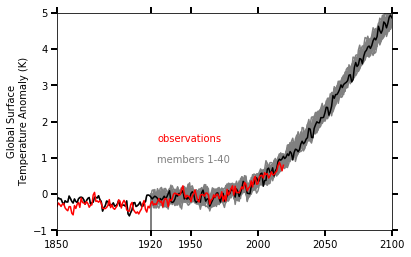

In [25]:
ax = plt.axes()

ax.tick_params(right=True, top=True, direction='out', length=6, width=2, grid_alpha=0.5)
ax.plot(years, all_ts_anom, color='grey')
ax.plot(years, all_ts_anom[1], color='black')
ax.plot(obs_s.index.year.tolist(), obs_s, color='red')

ax.text(0.3, 0.4, 'observations',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='red', fontsize=10)
ax.text(0.3, 0.3, 'members 1-40',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='grey', fontsize=10)

ax.set_xticks([1850, 1920, 1950, 2000, 2050, 2100])
plt.ylim(-1, 5)
plt.xlim(1850, 2100)
plt.ylabel('Global Surface\nTemperature Anomaly (K)')
plt.show()

## Compute Linear Trend for boreal winter seasons (DJF)

In [26]:
def linear_trend(da, dim='time'):
    da_chunk = da.chunk({dim: -1})
    trend = xr.apply_ufunc(calc_slope, da_chunk,
                           vectorize=True,
                           input_core_dims=[[dim]],
                           output_core_dims=[[]],
                           output_dtypes=[np.float],
                           dask='parallelized')
    return trend
    

def calc_slope(y):
    """ufunc to be used by linear_trend"""
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0]

In [27]:
# TODO - this should probably include only full seasons from 1979 and 2012
t = xr.concat([t_20c, t_rcp], dim='time')
seasons = t.sel(time=slice('1979', '2012')).resample(time='QS-DEC').mean('time').load()

In [28]:
winter_seasons = seasons.sel(time=seasons.time.where(seasons.time.dt.month == 12, drop=True))
winter_trends = linear_trend(winter_seasons.chunk({'lat': 20, 'lon': 20, 'time': -1}))\
                .load() * len(winter_seasons.time)

In [29]:
# TODO: this should be 34 I think, its not!
# assert len(winter_seasons.time) == 34  

In [30]:
len(winter_seasons.time)

35

## Figure 4: Global maps of historical (1979 - 2012) boreal winter (DJF) surface air trends

![kay-et-al-2015-figure-4](../../../assets/kay-et-al-2015-figure-4.png)

In [31]:
import cartopy.crs as ccrs

<Figure size 1800x1200 with 0 Axes>

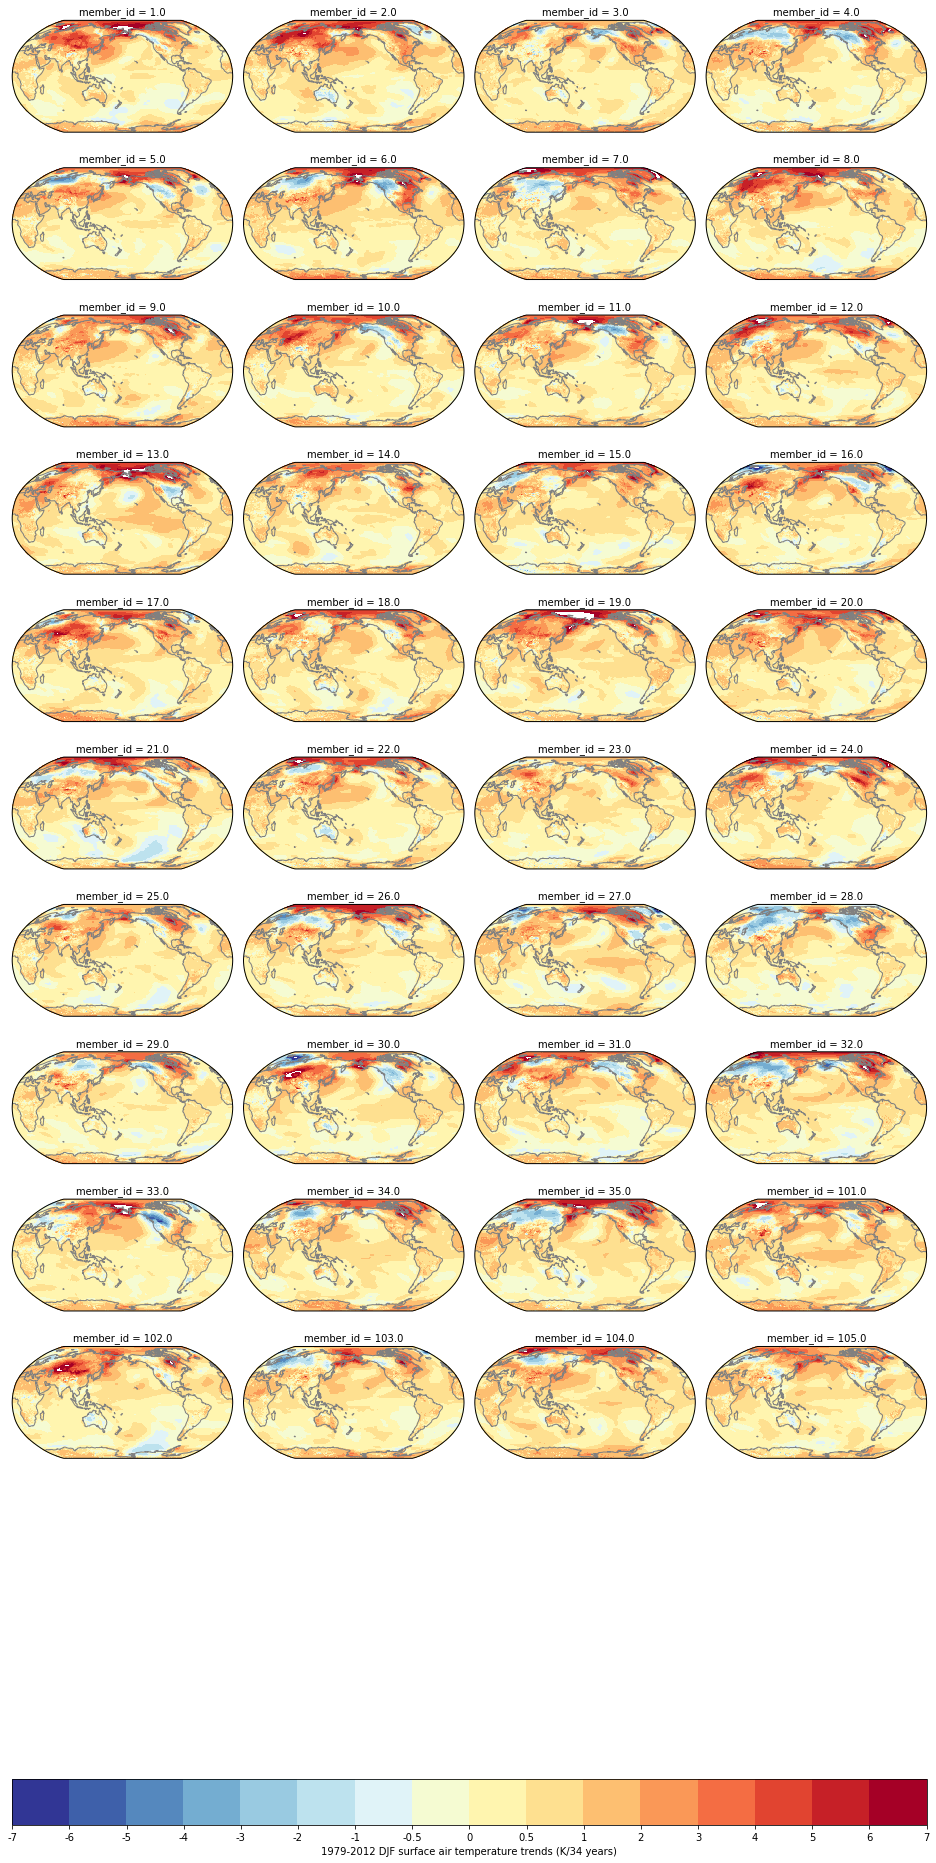

In [32]:
fig = plt.figure(dpi=300)
levels = [-7, -6, -5, -4, -3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 4, 5, 6, 7]
fg = winter_trends.plot(col='member_id', col_wrap=4, transform=ccrs.PlateCarree(),
            subplot_kws={'projection': ccrs.Robinson(central_longitude=180)},
            add_colorbar=False, levels=levels, cmap='RdYlBu_r', extend='neither')

for ax in fg.axes.flat:
    ax.coastlines(color='grey')
    
# TODO: move the subplot title to lower left corners
# TODO: Add obs panel and ensemble mean at the end
    
fg.add_colorbar(orientation='horizontal')
fg.cbar.set_label('1979-2012 DJF surface air temperature trends (K/34 years)')
fg.cbar.set_ticks(levels)
fg.cbar.set_ticklabels(levels)
plt.show()

## Going Further